In [ ]:
!tar -czvf trained_models_2.tar.gz /content/trained_models_2

In [ ]:
# mount it
from google.colab import drive
drive.mount('/content/drive')
# copy it there
!cp trained_models_2.tar.gz /content/drive/MyDrive

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
#!unzip retinal-disease-classification.zip

In [23]:
import keras
import tensorflow as tf 
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns   
import cv2
from constants import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Rescaling, Input
from tensorflow.keras.applications import EfficientNetV2B3
from keras.optimizers import Adam

## Load and Inspect Images

In [23]:
# Read an image to see image specs 
img = cv2.imread(DATA_PATH +'train/benign/melanoma_0.jpg')
img.shape, img.min(), img.max()

((300, 300, 3), 26, 255)

In [8]:
batch_size = 32
train_gen = tf.keras.utils.image_dataset_from_directory(
            TRAIN_DIR,
            labels='inferred',
            label_mode='int',
            class_names=None,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(300, 300),
            shuffle=True,
            seed=SEED,
            interpolation='bilinear',
            crop_to_aspect_ratio=True,
        )

test_gen = tf.keras.utils.image_dataset_from_directory(
            TEST_DIR,
            labels='inferred',
            label_mode='int',
            class_names=None,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(300, 300),
            shuffle=True,
            seed=SEED,
            interpolation='bilinear',
            crop_to_aspect_ratio=True,
        )

Found 9605 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [60]:
# more image specs 
for (x, y) in train_gen.take(10):
    print(x.shape, x[0][0].numpy().min(), x[0][0].numpy().max(), y.shape)
    break
print(x.numpy().min(), x.numpy().max())   

(32, 300, 300, 3) 0 195 (32,)
0 255


In [61]:
def get_class_count(data_gen):
    # Get the class names from the dataset
    class_names = data_gen.class_names

    # Initialize a dictionary to store the counts of each class
    class_counts = {class_name: 0 for class_name in class_names}

    # Iterate through the dataset to count the occurrences of each class
    for images, labels in data_gen:
        for label in labels:
            class_name = class_names[label.numpy()]
            class_counts[class_name] += 1

    # Print the count of each class
    for class_name, count in class_counts.items():
        print(f'{class_name}: {count}')
        
# classes are closely balanced 
get_class_count(train_gen)

benign: 5000
malignant: 4605


2024-03-10 16:47:53.711283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


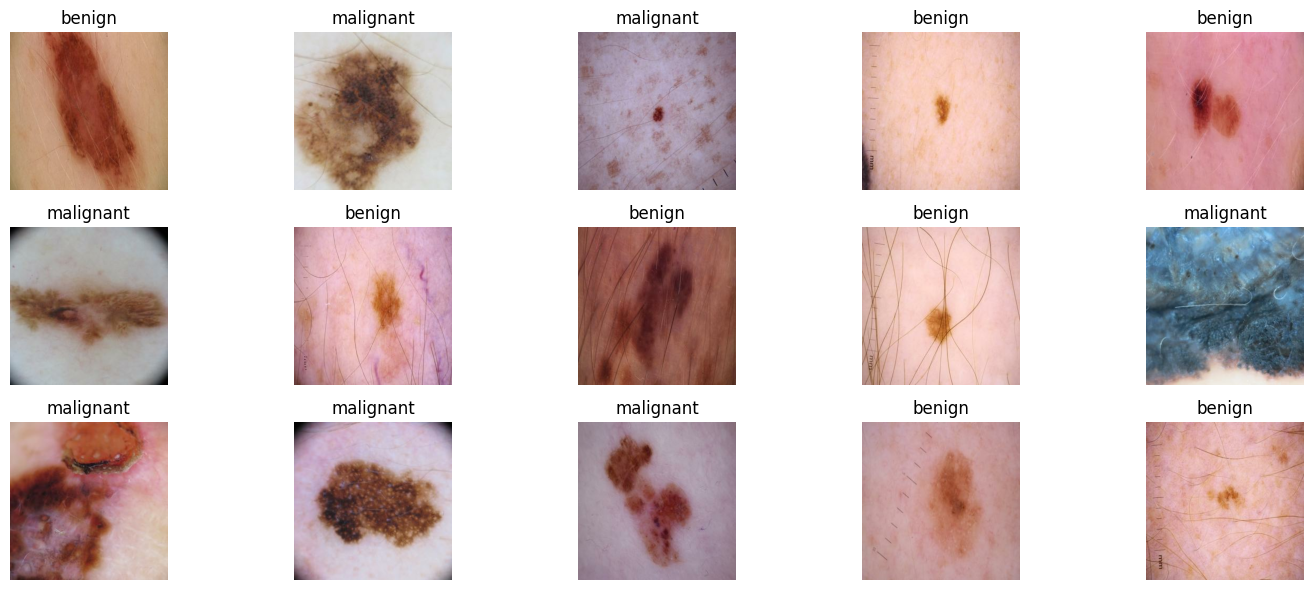

In [66]:
def plot_images(image_dataset):
    # Get the class names from the dataset
    class_names = image_dataset.class_names

    # Plot 10 subplots
    fig, axs = plt.subplots(3, 5, figsize=(15, 6))
    axs = axs.ravel()

    # Iterate through the dataset to plot images from different batches
    for i, (images, labels) in enumerate(image_dataset):
        if i == 15:  # Plot 15 batches (total of 320 images)
            break
        for image, label in zip(images, labels):
            class_name = class_names[label.numpy()]
            axs[i].imshow(image.numpy().astype('uint8'))
            axs[i].set_title(class_name)
            axs[i].axis('off')

    plt.tight_layout()
    plt.show()
    
plot_images(train_gen)
# benign and malignant skin patches look similar although there are some differences
# malignant tend to have a darker color, the model will have to identify if not all most differences 

### Notes

- Class are closely balanced:
    - benign: 5000
    - malignant: 4605

- Original images are relatively small, 300x300
    - Pre-trained models typically want images at around 225x225

- Train set has a relatively large number of images from each class, ignore image augmentation for now

## Models

In [26]:
def create_alexnet_model(input_shape, batch_size):
    model = Sequential([
        Input(shape=input_shape, batch_size=batch_size),
        Rescaling(1./255),
        Conv2D(96, (11, 11), strides=(4, 4), activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') # binary classification 
    ])
    return model

def create_efficient_net_model(input_shape, batch_size):

    # Load pre-trained EfficientNetV2B3 model without including top layers (fully connected layers)
    base_model = EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = False

    # Add custom top layers for binary classification
    model = tf.keras.Sequential([
        Input(shape=input_shape, batch_size=batch_size),
        Rescaling(1./255),
        base_model,
        GlobalAveragePooling2D(),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(2096, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') # binary classification
    ])
    
    return model 

In [27]:
batch_size = 32
epochs = 3
input_shape = (300, 300, 3)
lr=0.001

In [28]:
alex_net = create_alexnet_model(input_shape, batch_size)

alex_net.compile(optimizer=Adam(lr), 
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

alex_net.fit(train_gen,
    batch_size=batch_size,  
    epochs=epochs,    
    shuffle=True,  
    validation_data=test_gen   
)

alex_net.save('alex_net_model.keras')

Epoch 1/3
  2/301 ━━━━━━━━━━━━━━━━━━━━ 11:48 2s/step - accuracy: 0.5312 - loss: 12.0493

KeyboardInterrupt: 

In [29]:
eff_net  = create_efficient_net_model(input_shape, batch_size)

eff_net.compile(optimizer=Adam(lr), 
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

eff_net.fit(train_gen,
    batch_size=batch_size,  
    epochs=epochs,    
    shuffle=True,  
    validation_data=test_gen   
)

eff_net.save('eff_net_model.keras')

Epoch 1/3
247/301 ━━━━━━━━━━━━━━━━━━━━ 2:39 3s/step - accuracy: 0.5075 - loss: 0.7955

KeyboardInterrupt: 